In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import random
from collections import Counter
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

for dirname,_,finenames in os.walk('/kaggle/input'):
    for filename in finenames:
        print(os.path.join(dirname,filename))

2025-10-10 13:41:25.159325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760103685.367615      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760103685.421532      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/oral-cancer-dataset/Oral Cancer/Oral Cancer Dataset/CANCER/266.jpeg
/kaggle/input/oral-cancer-dataset/Oral Cancer/Oral Cancer Dataset/CANCER/071.jpeg
/kaggle/input/oral-cancer-dataset/Oral Cancer/Oral Cancer Dataset/CANCER/344.jpeg
/kaggle/input/oral-cancer-dataset/Oral Cancer/Oral Cancer Dataset/CANCER/228.jpeg
/kaggle/input/oral-cancer-dataset/Oral Cancer/Oral Cancer Dataset/CANCER/099.jpeg
/kaggle/input/oral-cancer-dataset/Oral Cancer/Oral Cancer Dataset/CANCER/130.jpeg
/kaggle/input/oral-cancer-dataset/Oral Cancer/Oral Cancer Dataset/CANCER/158.jpeg
/kaggle/input/oral-cancer-dataset/Oral Cancer/Oral Cancer Dataset/CANCER/003.jpeg
/kaggle/input/oral-cancer-dataset/Oral Cancer/Oral Cancer Dataset/CANCER/253.jpeg
/kaggle/input/oral-cancer-dataset/Oral Cancer/Oral Cancer Dataset/CANCER/014.jpeg
/kaggle/input/oral-cancer-dataset/Oral Cancer/Oral Cancer Dataset/CANCER/381.jpeg
/kaggle/input/oral-cancer-dataset/Oral Cancer/Oral Cancer Dataset/CANCER/263.jpeg
/kaggle/input/or

In [2]:
dataset1 = "/kaggle/input/oral-cancer-dataset/Oral Cancer/Oral Cancer Dataset"
dataset2 = "/kaggle/input/oral-cancer-dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new"
merged_dataset = "/kaggle/working/merged_oral_cancer_dataset"

os.makedirs(merged_dataset, exist_ok=True)
for cls in ["CANCER", "NON CANCER"]:
    os.makedirs(os.path.join(merged_dataset, cls), exist_ok=True)

def merge_folders(src_folder, dst_folder):
    if not os.path.exists(src_folder):
        print(f"Warning: src_folder not found: {src_folder}")
        return
    for root, _, files in os.walk(src_folder):
        for file in files:
            if not file.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            src_file = os.path.join(root, file)
            dst_file = os.path.join(dst_folder, file)
            if os.path.exists(dst_file):
                base, ext = os.path.splitext(file)
                i = 1
                while os.path.exists(os.path.join(dst_folder, f"{base}_copy{i}{ext}")):
                    i += 1
                dst_file = os.path.join(dst_folder, f"{base}_copy{i}{ext}")
            shutil.copy(src_file, dst_file)

for cls in ["CANCER", "NON CANCER"]:
    merge_folders(os.path.join(dataset1, cls), os.path.join(merged_dataset, cls))
    merge_folders(os.path.join(dataset2, cls), os.path.join(merged_dataset, cls))

print("Merging complete. Final dataset at:", merged_dataset)

Merging complete. Final dataset at: /kaggle/working/merged_oral_cancer_dataset


In [3]:
sizes = []
removed_files = []
for cls in ["CANCER", "NON CANCER"]:
    folder = os.path.join(merged_dataset, cls)
    if not os.path.exists(folder):
        continue
    for file in os.listdir(folder):
        if not file.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        img_path = os.path.join(folder, file)
        try:
            with Image.open(img_path) as im:
                im.verify() 
            with Image.open(img_path) as im2:
                sizes.append(im2.size)
        except (UnidentifiedImageError, OSError) as e:
            print(f"Skipping corrupted file: {img_path} -> {e}")
            try:
                os.remove(img_path)
                removed_files.append(img_path)
            except:
                pass

size_counts = Counter(sizes)
print("Top 10 most common image sizes:")
for size, count in size_counts.most_common(10):
    print(size, ":", count)


print(f"Total corrupted files removed: {len(removed_files)}")

Top 10 most common image sizes:
(280, 205) : 62
(960, 1280) : 28
(275, 183) : 18
(468, 1040) : 18
(720, 1280) : 13
(1800, 4000) : 10
(1280, 720) : 8
(1100, 618) : 8
(4000, 3000) : 8
(225, 225) : 7
Total corrupted files removed: 0


In [4]:
import matplotlib.image as mpimg
classes = ["CANCER", "NON CANCER"]
all_images = []
for cls in classes:
    folder = os.path.join(merged_dataset, cls)
    images = [os.path.join(folder, img) for img in os.listdir(folder) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for img_path in images:
        all_images.append((img_path, cls))
        
sample_images = random.sample(all_images, 5)

# Plot them
plt.figure(figsize=(15, 8))
for i, (img_path, cls) in enumerate(sample_images):
    img = mpimg.imread(img_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
input_base = merged_dataset
preprocessed_base = "/kaggle/working/preprocessed_oral_cancer_dataset"
os.makedirs(preprocessed_base, exist_ok=True)

for cls in ["CANCER", "NON CANCER"]:
    os.makedirs(os.path.join(preprocessed_base, cls), exist_ok=True)

for cls in ["CANCER", "NON CANCER"]:
    folder = os.path.join(input_base, cls)
    out_folder = os.path.join(preprocessed_base, cls)
    if not os.path.exists(folder):
        continue
    for file in tqdm(os.listdir(folder), desc=f"Preprocessing {cls}"):
        if not file.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        src = os.path.join(folder, file)
        dst = os.path.join(out_folder, file)
        try:
            img = cv2.imread(src)
            if img is None:
                print("Unreadable:", src)
                continue

            # Resize
            img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LANCZOS4)

            # Save preprocessed image
            cv2.imwrite(dst, img)
        except Exception as e:
            print("Error processing", src, e)

print("Preprocessing complete.")

Preprocessing NON CANCER: 100%|██████████| 700/700 [00:09<00:00, 77.16it/s] 

Preprocessing complete.


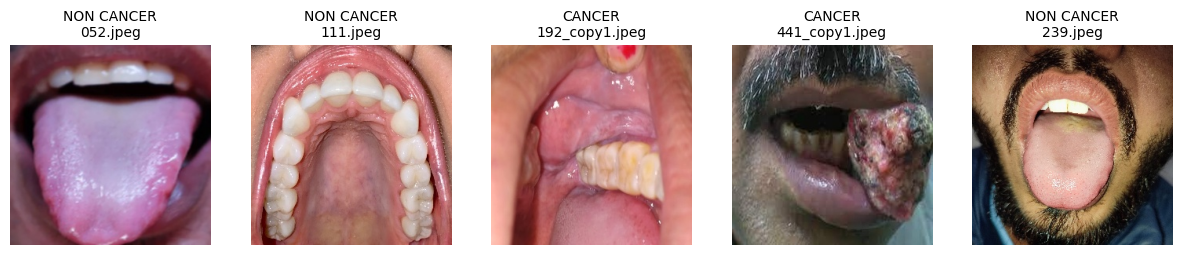

In [6]:
all_images = []
for cls in ["CANCER", "NON CANCER"]:
    folder = os.path.join(preprocessed_base, cls)
    all_images += [(os.path.join(folder, f), cls) for f in os.listdir(folder) 
                   if f.lower().endswith((".jpg", ".jpeg", ".png"))]

# Pick 5 random images
random_images = random.sample(all_images, min(5, len(all_images)))

# Display images with labels
plt.figure(figsize=(15,5))
for i, (img_path, label) in enumerate(random_images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"{label}\n{os.path.basename(img_path)}", fontsize=10)
    plt.axis("off")
plt.show()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

def random_contrast(image, lower=0.8, upper=1.2):
    image = tf.image.random_contrast(image, lower=lower, upper=upper)
    image = tf.clip_by_value(image, 0, 255)
    return tf.cast(image, tf.uint8)

preprocessed_folder = preprocessed_base  
aug_folder = "/kaggle/working/augmented_oral_cancer_dataset"
os.makedirs(aug_folder, exist_ok=True)
for cls in ["CANCER", "NON CANCER"]:
    os.makedirs(os.path.join(aug_folder, cls), exist_ok=True)

orig_counts = {
    cls: len([
        f for f in os.listdir(os.path.join(preprocessed_folder, cls))
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ])
    for cls in ["CANCER", "NON CANCER"]
}
print("Before Augmentation:")
for cls in orig_counts:
    print(f"  {cls}: {orig_counts[cls]} images")
print(f"  Total: {sum(orig_counts.values())}\n")

datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.8, 1.2),
    fill_mode='nearest'
)

N = 3 
for cls in ["CANCER", "NON CANCER"]:
    in_folder = os.path.join(preprocessed_folder, cls)
    out_folder = os.path.join(aug_folder, cls)
    for fname in tqdm(
        [f for f in os.listdir(in_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))],
        desc=f"Augmenting {cls}"
    ):
        src = os.path.join(in_folder, fname)
        try:
            img = tf.keras.preprocessing.image.load_img(src)
            arr = tf.keras.preprocessing.image.img_to_array(img).astype('uint8')

            orig_name = os.path.splitext(fname)[0] + "_orig.png"
            tf.keras.preprocessing.image.save_img(os.path.join(out_folder, orig_name), arr)

            x = arr.reshape((1,) + arr.shape)  # (1, H, W, C)
            it = datagen.flow(x, batch_size=1)
            for i in range(N):
                batch = next(it)
                aug_img = batch[0].astype('uint8')

                aug_img = random_contrast(aug_img).numpy()

                aug_name = os.path.splitext(fname)[0] + f"_aug{i}.png"
                tf.keras.preprocessing.image.save_img(os.path.join(out_folder, aug_name), aug_img)

        except Exception as e:
            print("Augmentation error for", src, e)

aug_counts = {
    cls: len([
        f for f in os.listdir(os.path.join(aug_folder, cls))
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ])
    for cls in ["CANCER", "NON CANCER"]
}
print("After Augmentation (before balancing):")
for cls in aug_counts:
    print(f"  {cls}: {aug_counts[cls]} images")
print(f"  Total: {sum(aug_counts.values())}\n")

Before Augmentation:
  CANCER: 1000 images
  NON CANCER: 700 images
  Total: 1700



Augmenting NON CANCER: 100%|██████████| 700/700 [01:51<00:00,  6.30it/s]

After Augmentation (before balancing):
  CANCER: 4000 images
  NON CANCER: 2800 images
  Total: 6800



In [8]:
max_count = max(aug_counts.values())
for cls in ["CANCER", "NON CANCER"]:
    folder = os.path.join(aug_folder, cls)
    files = [f for f in os.listdir(folder) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    if len(files) == 0:
        continue
    i = 0
    while len(files) < max_count:
        f = random.choice(files)
        src = os.path.join(folder, f)
        dst = os.path.join(folder, f"copy_{i}_{f}")
        shutil.copy(src, dst)
        files.append(os.path.basename(dst))
        i += 1

final_counts = {cls: len([f for f in os.listdir(os.path.join(aug_folder, cls))
                          if f.lower().endswith((".png", ".jpg", ".jpeg"))]) for cls in ["CANCER", "NON CANCER"]}
print("After Balancing:")
for cls in final_counts:
    print(f"  {cls}: {final_counts[cls]} images")
print(f"  Total: {sum(final_counts.values())}\n")

After Balancing:
  CANCER: 4000 images
  NON CANCER: 4000 images
  Total: 8000



In [9]:
split_folder = "/kaggle/working/split_dataset"
for split in ["train", "val", "test"]:
    for cls in ["CANCER", "NON CANCER"]:
        os.makedirs(os.path.join(split_folder, split, cls), exist_ok=True)

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15 

for cls in ["CANCER", "NON CANCER"]:
    cls_path = os.path.join(aug_folder, cls)
    imgs = [f for f in os.listdir(cls_path) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    random.shuffle(imgs)
    n_total = len(imgs)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    train_imgs = imgs[:n_train]
    val_imgs = imgs[n_train:n_train+n_val]
    test_imgs = imgs[n_train+n_val:]
    for f in train_imgs:
        shutil.copy(os.path.join(cls_path, f), os.path.join(split_folder, "train", cls, f))
    for f in val_imgs:
        shutil.copy(os.path.join(cls_path, f), os.path.join(split_folder, "val", cls, f))
    for f in test_imgs:
        shutil.copy(os.path.join(cls_path, f), os.path.join(split_folder, "test", cls, f))

print("Dataset successfully split into train/val/test.")

Dataset successfully split into train/val/test.


In [10]:
BATCH_SIZE = 16
IMG_SIZE = (256, 256)

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(split_folder, "train"),
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(split_folder, "val"),
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=42
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(split_folder, "test"),
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)

normalization = layers.Rescaling(1./255)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (normalization(x), y)).cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization(x), y)).cache().prefetch(AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (normalization(x), y)).cache().prefetch(AUTOTUNE)

Found 5600 files belonging to 2 classes.
Found 1200 files belonging to 2 classes.
Found 1200 files belonging to 2 classes.
Classes: ['CANCER', 'NON CANCER']


Model: "AOX_Model_Modified_BN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ re_lu_1[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ re_lu_2[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │      2,048 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      2,048 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 128) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 32, 32,    │          0 │ re_lu_2[0][0],    │
│                     │ 128)              │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │    147,584 │ multiply[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 525,890 (2.01 MB)

 Trainable params: 524,930 (2.00 MB)

 Non-trainable params: 960 (3.75 KB)

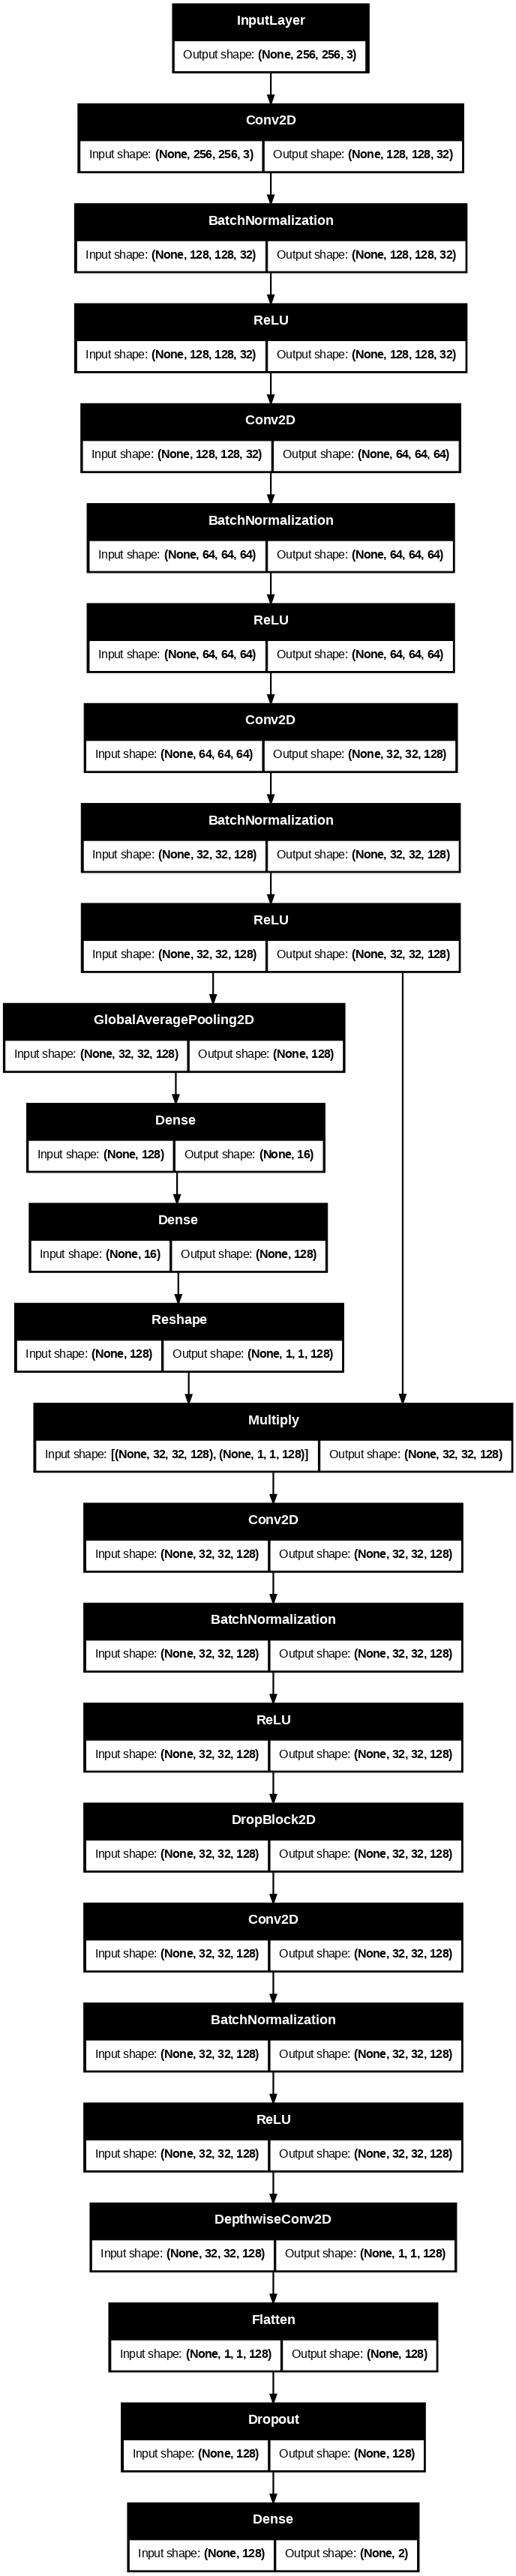

In [11]:
class DropBlock2D(layers.Layer):
    def __init__(self, drop_prob=0.1, block_size=7, **kwargs):
        super(DropBlock2D, self).__init__(**kwargs)
        self.drop_prob = drop_prob
        self.block_size = block_size

    def call(self, x, training=None):
        if not training or self.drop_prob == 0.0:
            return x
        h, w = x.shape[1], x.shape[2]
        gamma = self.drop_prob * (h * w) / (self.block_size**2) / ((h - self.block_size + 1) * (w - self.block_size + 1))
        mask = tf.cast(tf.random.uniform((tf.shape(x)[0], h, w, 1)) < gamma, x.dtype)
        mask = tf.nn.max_pool2d(mask, ksize=self.block_size, strides=1, padding="SAME")
        mask = 1 - mask
        x = x * mask * (tf.cast(tf.size(mask), tf.float32) / tf.reduce_sum(mask))
        return x

def SEBlockKeras(input_tensor, reduction=8):
    channels = int(input_tensor.shape[-1])
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(channels // reduction, activation='relu', use_bias=False)(se)
    se = layers.Dense(channels, activation='sigmoid', use_bias=False)(se)
    se = layers.Reshape((1, 1, channels))(se)
    x = layers.Multiply()([input_tensor, se])
    return x

def AOX_Model_Keras_Modified(input_shape=(256,256,3), num_classes=2, drop_prob=0.1):
    inputs = keras.Input(shape=input_shape)

    # Use existing data augmentation
    x = inputs

    # Conv Layers + BatchNorm + Activation
    x = layers.Conv2D(32, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(64, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Squeeze-Excitation Block
    x = SEBlockKeras(x, reduction=8)

    # More Conv + DropBlock + BatchNorm
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = DropBlock2D(drop_prob=drop_prob, block_size=5)(x)

    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Global Depthwise Conv + Flatten
    spatial_size = x.shape[1]  # current height
    x = layers.DepthwiseConv2D(kernel_size=spatial_size, padding='valid', activation='relu')(x)
    x = layers.Flatten()(x)

    # Dropout before classifier
    x = layers.Dropout(0.4)(x)

    # Final Dense
    # outputs = layers.Dense(num_classes, activation='softmax')(x)
    outputs = layers.Dense(2, activation='softmax')(x)


    model = keras.Model(inputs, outputs, name="AOX_Model_Modified_BN")
    return model

model = AOX_Model_Keras_Modified(input_shape=(256,256,3), drop_prob=0.1)
model.summary()
keras.utils.plot_model(model, expand_nested=True, dpi=80, show_shapes=True)

In [12]:
EPOCHS = 50
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = keras.callbacks.ModelCheckpoint("/kaggle/working/best_aox_model.h5", save_best_only=True, monitor='val_loss')

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

model.save("/kaggle/working/final_aox_model_keras.h5")
print("Model saved.")

Epoch 1/50


I0000 00:00:1760104021.203422     102 service.cc:148] XLA service 0x7e98bc08fc80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760104021.204225     102 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1760104021.827979     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


  7/350 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5572 - loss: 0.6860   

I0000 00:00:1760104026.451704     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


350/350 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - accuracy: 0.6910 - loss: 0.5825 - val_accuracy: 0.6217 - val_loss: 0.6354 - learning_rate: 1.0000e-04
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8264 - loss: 0.4043 - val_accuracy: 0.8583 - val_loss: 0.3295 - learning_rate: 1.0000e-04
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8736 - loss: 0.3154 - val_accuracy: 0.8517 - val_loss: 0.3243 - learning_rate: 1.0000e-04
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8864 - loss: 0.2731 - val_accuracy: 0.9008 - val_loss: 0.2491 - learning_rate: 1.0000e-04
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9191 - loss: 0.2159 - val_accuracy: 0.9058 - val_loss: 0.2259 - learning_rate: 1.0000e-04
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9299 - loss: 0.1872 - val_accuracy: 0.8608 - val_loss: 0.3082 - learning_rate: 1.0000e-04
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9

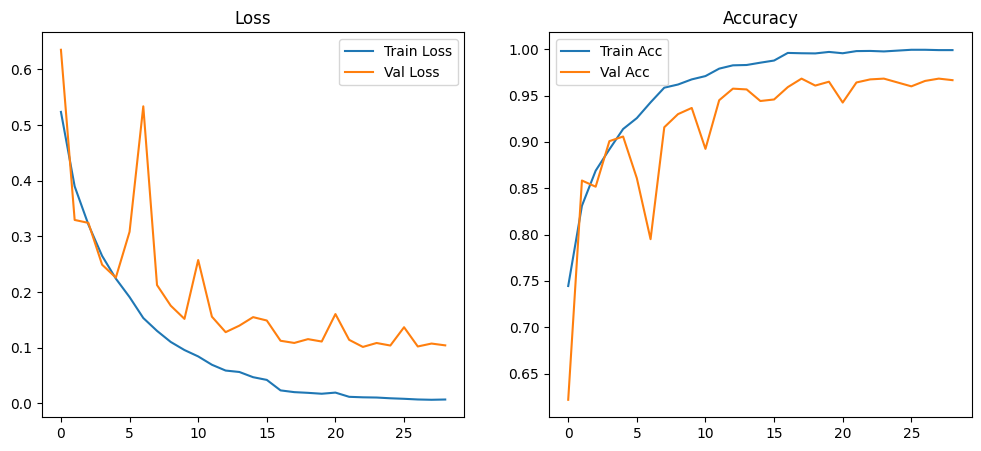

In [13]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
Test Accuracy: 0.9617
Classification Report:
              precision    recall  f1-score   support

      CANCER       0.96      0.96      0.96       600
  NON CANCER       0.96      0.96      0.96       600

    accuracy                           0.96      1200
   macro avg  

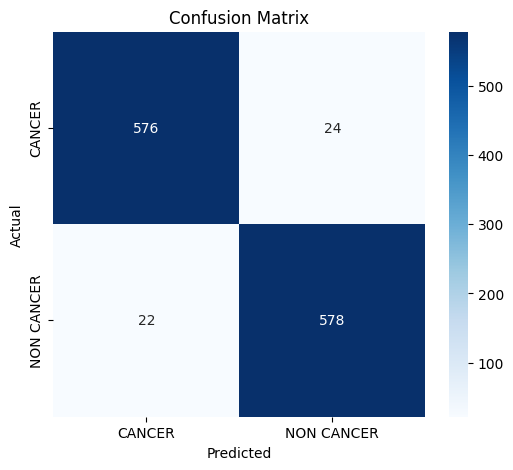

Keras pipeline finished. Model, plots and architecture diagram saved in /kaggle/working/


In [14]:
import seaborn as sns

y_true = []
y_pred = []
for x_batch, y_batch in test_ds.unbatch().batch(64): 
    preds = model.predict(x_batch)
    y_true.extend(y_batch.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

test_acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Keras pipeline finished. Model, plots and architecture diagram saved in /kaggle/working/")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


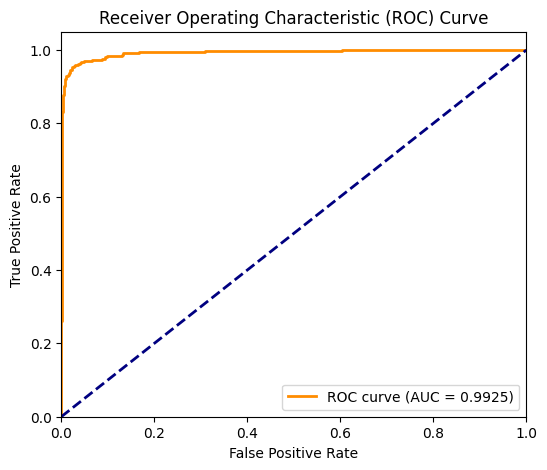

ROC AUC: 0.9925


In [15]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

y_true = np.array(y_true)
y_pred_probs = []

for x_batch, _ in test_ds.unbatch().batch(64):
    probs = model.predict(x_batch)
    y_pred_probs.extend(probs)
y_pred_probs = np.array(y_pred_probs)

if y_true.ndim > 1:
    y_true_indices = np.argmax(y_true, axis=1)
else:
    y_true_indices = y_true


fpr, tpr, _ = roc_curve(y_true_indices, y_pred_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC: {roc_auc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


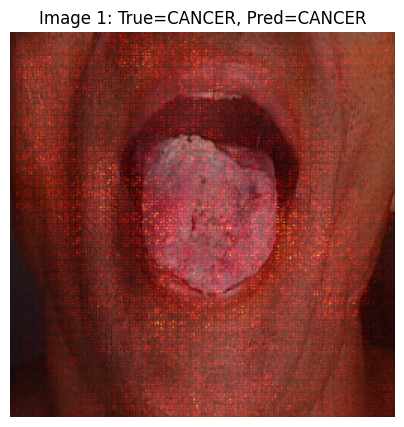

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


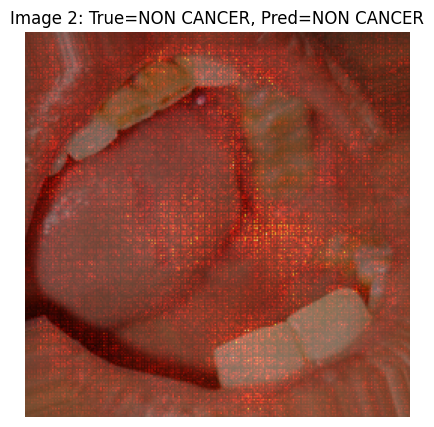

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


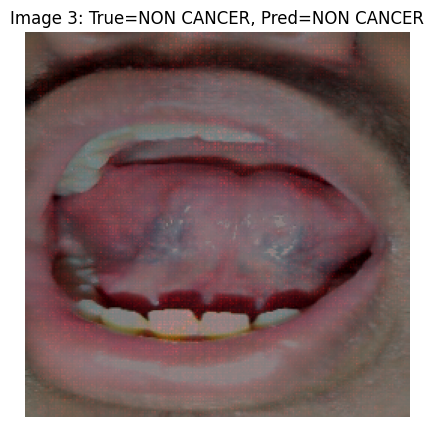

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


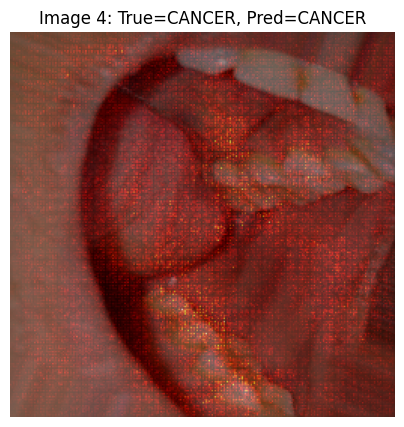

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


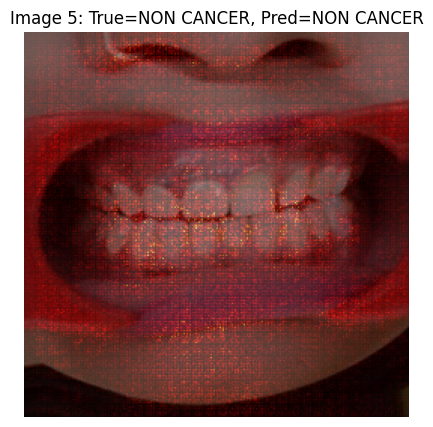

In [17]:
def compute_saliency(model, img_array, class_index=None):
    img_array = tf.convert_to_tensor(img_array)

    with tf.GradientTape() as tape:
        tape.watch(img_array) 
        preds = model(img_array)
        if class_index is None:
            class_index = tf.argmax(preds[0])
        loss = preds[:, class_index]


    grads = tape.gradient(loss, img_array)
    saliency = tf.abs(grads)
    saliency = tf.reduce_max(saliency, axis=-1) 
    saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency) + 1e-8)  # normalize 0-1
    return saliency.numpy().squeeze()


N = 5 
test_images = list(test_ds.unbatch()) 
random_samples = random.sample(test_images, N)

for i, (img_tensor, label_tensor) in enumerate(random_samples):
    img_array = img_tensor[tf.newaxis, ...]  

    saliency_map = compute_saliency(model, img_array)

    img = img_tensor.numpy()  
    heatmap = plt.cm.hot(saliency_map)[..., :3] 
    superimposed_img = 0.5*img + 0.5*heatmap

    plt.figure(figsize=(5,5))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title(f"Image {i+1}: True={class_names[label_tensor.numpy()]}, Pred={class_names[np.argmax(model.predict(img_array))]}")
    plt.show()